In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN0-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN4-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN11-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN1-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN1-dir.png
/kag

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

2025-05-05 03:00:50.927686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746414051.126327      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746414051.181790      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_dataset():
    # Base directories
    train_dir = "/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"
    
    # Find the DOENTES and SAUDÁVEIS directories
    train_folders = os.listdir(train_dir)
    doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
    saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])
    
    # Function to load images from the "Segmentadas" subdirectories
    def load_images_from_segmentadas(directory, label):
        images = []
        labels = []
        
        for root, dirs, files in os.walk(directory):
            # Only process files inside "Segmentadas" subdirectories
            if "Segmentadas" in root:
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    
                    # Skip non-image files
                    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        continue
                    
                    # Preprocess the image
                    img = preprocess_image(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        
        return images, labels
    
    # Load images from both directories
    print("Loading cancer (DOENTES) images...")
    cancer_images, cancer_labels = load_images_from_segmentadas(doentes_dir, 1)
    
    print("Loading healthy (SAUDÁVEIS) images...")
    healthy_images, healthy_labels = load_images_from_segmentadas(saudaveis_dir, 0)
    
    # Combine datasets
    all_images = cancer_images + healthy_images
    all_labels = cancer_labels + healthy_labels
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    # Print the shape before conversion
    print(f"Dataset shape before RGB conversion: {X.shape}")
    
    # Convert grayscale to RGB (duplicate channels)
    if X.ndim == 3:  # If shape is (n, 224, 224)
        X = np.stack([X, X, X], axis=-1)
    
    # Print the shape after conversion
    print(f"Dataset shape after RGB conversion: {X.shape}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


In [4]:
# Function to preprocess images
def preprocess_image(img_path):
    # Read image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Noise reduction using median filtering
    img = cv2.medianBlur(img, 3)
    
    # Resize to 224x224 (standard for CNNs)
    img = cv2.resize(img, (224, 224))
    
    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0

    return img

In [6]:
from tensorflow.keras.layers import Attention, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Custom layer to reshape the tensor for attention
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Reshape for Attention: (batch_size, 1, feature_size)
        x = tf.expand_dims(inputs, axis=1)
        attention = Attention()([x, x])  # Apply attention
        return attention

def build_hifuse_model(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)

    # Use a pre-trained VGG19 model
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Apply Convolution and Pooling
    x = base_model.output
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten the output from the convolution layer
    x = Flatten()(x)
    
    # Apply custom attention layer
    x = AttentionLayer()(x)
    
    # Flatten and continue the network
    x = Flatten()(x)
    
    # Dense Layers for Classification
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Build the model
    model = Model(inputs=input_tensor, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model


Loading and preprocessing the dataset...
Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224)
Dataset shape after RGB conversion: (1282, 224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.5803 - loss: 1.6378 - val_accuracy: 0.8288 - val_loss: 0.3585
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 578ms/step - accuracy: 0.8319 - loss: 0.3637 - val_accuracy: 0.8988 - val_loss: 0.2596
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 560ms/step - accuracy: 0.8924 - loss: 0.2516 - val_accuracy: 0.9377 - val_loss: 0.1731
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 539ms/step - accuracy: 0.9146 - loss: 0.1955 - val_accuracy: 0.9494 - val_loss: 0.1168
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 522ms/step - accuracy: 0.9634 - loss: 0.1063 - val_accuracy: 0.9728 - val_loss: 0.0868
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - accuracy: 0.9813 - loss: 0.0597 - val_accuracy: 0.9883 - val_loss: 0.0433
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - accuracy: 0.9920 - loss: 0.0377 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 480ms/step - accuracy: 0.9989 - loss: 0.0198 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00       140

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Confusion Matrix:
[[117   0]
 [  0 140]]

AUC (Area Under the Curve): 1.0000

Cohen's Kappa: 1.0000


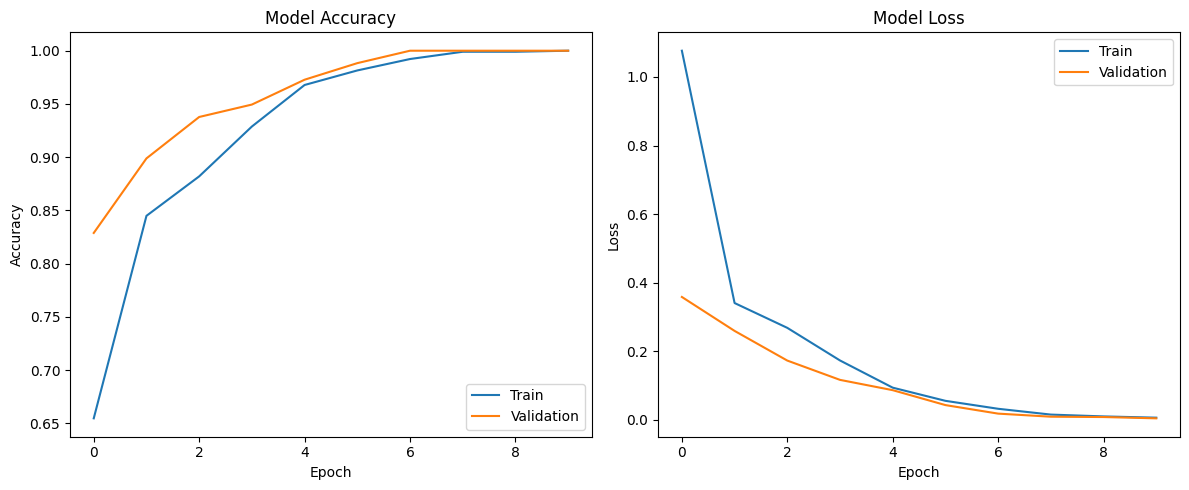

<Functional name=functional_3, built=True>

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_and_evaluate_hifuse(X_train, X_test, y_train, y_test):
    # Build the HiFuse model
    model = build_hifuse_model()
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_breast_cancer_model_hifuse.keras', monitor='val_accuracy', 
                                       save_best_only=True, mode='max')
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=64,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    
    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_binary)
    print(cm)
    
    # AUC - Area Under the Curve
    auc = roc_auc_score(y_test, y_pred)
    print(f"\nAUC (Area Under the Curve): {auc:.4f}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred_binary)
    print(f"\nCohen's Kappa: {kappa:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_history_hifuse.png')
    plt.show()

    return model

# Load and preprocess the dataset
print("Loading and preprocessing the dataset...")
X_train, X_test, y_train, y_test = load_dataset()

# Train and evaluate the HiFuse model
train_and_evaluate_hifuse(X_train, X_test, y_train, y_test)
